# Choose settings

##### Choose your settings here

In [ ]:
# choose dataset
DATASET_NAME = 'cats-vs-dogs-large'  # needs to match folder name in FM/datasets
LOAD_AND_EMBED_DATASET_IN_BATCHES = True  # True for large datasets, False for small ones
USE_CACHED_EMBEDDINGS = 'ALIGN_cats-vs-dogs-large.pkl'  # '' for loading the dataset normally, 'CREATE__{x}.pkl' for creating the cache file {x}.pkl, '{x}.pkl' for loading the cache file {x}.pkl
MISLABELED_INSTANCES = 'mislabeled_instances_cats-vs-dogs.pkl'  # if not '', but e.g. 'mislabeled_instances_cats-vs-dogs.pkl', the pickle file specifies which files to drop from the loaded embeddings

# choose how many image-label mismatches to insert
MISMATCH_PORTION = 0.01  # percentage of mismatching image-label pairs added
MANIPULATION_TYPES = [0.5, 0.5, 0.0, 0.0]  # how much of the MISMATCH_PORTION to produce by [exchanging images between classes, inserting images from other datasets, inserting randomly generated images, inserting placeholder images]
IMAGENET_EMBEDDINGS = 'ALIGN_imagenet-subset.pkl'  # specify if MANIPULATION_TYPES[1] > 0

# choose strategies to find mismatches
# options: ['fixed_reference_vector', 'mean_vector', 'median_vector', 'most_similar_vector', 'text_embedding_vector', 'pairwise_similarity', 'self_similarity']
STRATEGIES = ['mean_vector']#, 'median_vector', 'most_similar_vector', 'pairwise_similarity']

# choose which model to use to generate the embeddings
MODEL = 'ALIGN'  # Can be 'CLIP', 'AlexNet', 'ViT-pooling', 'ViT-CLS' or 'ALIGN'

PLOT_DPI = 75  # 75 for small figures and 300 for good quality

##### This part is calculated automatically

In [ ]:
root_path = '/content/drive/My Drive/FM/'
datasets_path = root_path + 'datasets/'
dataset_path = datasets_path + DATASET_NAME + '/'

if DATASET_NAME == 'cats-vs-dogs-large' or DATASET_NAME == 'train-small':
  LABELS = ['cat', 'dog']
elif DATASET_NAME == 'jellyfish-classification':
  LABELS = ['barrel jellyfish', 'compass jellyfish', 'lions mane jellyfish', 'moon jellyfish']
elif DATASET_NAME == 'traffic-signs':
  LABELS = ['30 kilometers per hour speed limit traffic sign', '80 kilometers per hour speed limit traffic sign', '100 kilometers per hour speed limit traffic sign', 'give way traffic sign', 'no entry traffic sign', 'no overtaking traffic sign', 'priority over oncoming traffic sign', 'stop sign']
else:
  raise ValueError('Invalid dataset selected or labels not set!')

assert 0 <= MISMATCH_PORTION <= 1, f'MISMATCH_PORTION must be in [0, 1] but is {MISMATCH_PORTION}'
assert len(MANIPULATION_TYPES) == 4 and sum(MANIPULATION_TYPES) == 1, f'MANIPULATION_TYPES must contain 4 entries that sum up to 1.0 but is {MANIPULATION_TYPES}'
assert MANIPULATION_TYPES[0] + MANIPULATION_TYPES[1] == 1, 'At the moment, only interclass corruption and imagenet corruption are implemented!'
for strategy in STRATEGIES:
  assert strategy in ['fixed_reference_vector', 'mean_vector', 'median_vector', 'most_similar_vector', 'text_embedding_vector', 'pairwise_similarity', 'self_similarity'], f'Strategy {strategy} not implemented!'
assert MODEL in ['CLIP', 'AlexNet', 'ViT-pooling', 'ViT-CLS', 'ALIGN', 'SLIP'], f'Selected model {MODEL} not implemented!'
if 'text_embedding_vector' in STRATEGIES:
  assert MODEL in ['CLIP', 'ALIGN'], f'Only CLIP and ALIGN support "text_embedding_vector" strategy, but {MODEL} is selected!'

# Load libraries

In [ ]:
# hacky way when hitting "run all" that libraries are not reloaded
try:
  torch.tensor([[0]])
  libraries_already_loaded = True
except:
  libraries_already_loaded = False

In [ ]:
if not libraries_already_loaded:
  ! pip install ftfy regex tqdm
  ! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 798.7 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ekgh44hv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ekgh44hv
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=d191e43a18b24ab6e00cb1052be3c1dbeabc078faadabc75e59e3d55c6b28a79
  Stored in directory: /tmp/pip-ephem-wheel-cache-7aawz3fe/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
if not libraries_already_loaded:
  import torch
  from torchvision import transforms
  import clip
  from transformers import AutoImageProcessor, ViTModel, AlignProcessor, AlignModel, AutoTokenizer
  from transformers.tokenization_utils_base import BatchEncoding
  import numpy as np
  from matplotlib import pyplot as plt
  from PIL import Image
  from pkg_resources import packaging
  import os
  from google.colab import drive
  from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
  import glob
  import pickle
  from scipy.spatial.distance import cosine

print("Torch version:", torch.__version__)
plt.rcParams['figure.dpi'] = PLOT_DPI
plt.rcParams['savefig.dpi'] = PLOT_DPI

Torch version: 2.1.0+cu118


In [ ]:
def calculate_column_average(matrix):
    """
    Calculates the average for each column in a PyTorch matrix.

    Parameters:
    - matrix: torch.Tensor
        The input matrix for which the column averages are to be calculated.

    Returns:
    - torch.Tensor
        A tensor containing the average value for each column of the input matrix.

    Raises:
    - TypeError:
        Raises an error if the input is not a PyTorch tensor.
    - ValueError:
        Raises an error if the input tensor is empty or has zero columns.
    """

    # Checking if the input is a PyTorch tensor
    if not isinstance(matrix, torch.Tensor):
        raise TypeError("Input should be a PyTorch tensor.")

    # Checking if the input tensor is empty or has zero columns
    if matrix.numel() == 0 or matrix.size(1) == 0:
        raise ValueError("Input tensor is empty or has zero columns.")

    # Calculating the column averages but taking out the entry for the same vector in the matrix (diagonal entry)
    column_sums = torch.sum(matrix, dim=0)
    column_counts = torch.tensor([matrix.size(0)] * (matrix.size(1)), dtype=torch.float32)
    column_averages = (column_sums -1) / (column_counts - 1)

    return column_averages

def cosine_similarity_matrix(embeddings_tensor):
    """
    Function to compute a similarity matrix using dot product

    Parameters:
    - embeddings: list of torch.Tensor
        List of embeddings of images produced with CLIP.

    Returns:
    - similarity_matrix: numpy.ndarray
        2D numpy array representing the similarity matrix between the embeddings.
        Each element (i, j) in the matrix represents the similarity between embeddings[i] and embeddings[j].
        The similarity score between the two embeddings is calculated using cos similarity. The score ranges from 0 to 1,
        where 0 indicates completely dissimilar embeddings and 1 indicates identical embeddings.
    """

    """
    # Calculating the cosine distance between the two embeddings
    distance = cosine(embedding1, embedding2)

    # Converting the distance to similarity score
    similarity = 1 - distance

    return similarity
    """

    # Normalizing the embeddings
    embeddings_tensor = torch.nn.functional.normalize(embeddings_tensor, dim=1)

    # Computing the similarity matrix using dot product
    similarity_matrix = torch.matmul(embeddings_tensor, embeddings_tensor.T)

    return similarity_matrix

from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn
def cosine_similarity(x, y=None):
  if y is None:
    return cosine_similarity_matrix(x)
  return cosine_similarity_sklearn(x, y)

# Mounting storage

In [ ]:
drive.mount('/content/drive')
!ls "{root_path}"

NameError: ignored

# Load model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class AlexNetEmbedder(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.alexnet.features(x)
    x = self.alexnet.avgpool(x)
    return self.alexnet.classifier[:5](torch.flatten(x, 1))

  def encode_image(self, img: torch.Tensor) -> torch.Tensor:
    return self(img)


class VisionTransformer(torch.nn.Module):

  def __init__(self, use_pooler_output_instead_of_last_hidden_state=False):
    super().__init__()
    self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    self.use_pooler_output = use_pooler_output_instead_of_last_hidden_state

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    out = self.vit(x, return_dict=True)
    if self.use_pooler_output:
      return out.pooler_output
    else:
      return out.last_hidden_state[:, 0, :]

  def encode_image(self, img: torch.Tensor) -> torch.Tensor:
    return self(img)


def vit_preprocessor_with_memory_fix(img) -> torch.Tensor:
  processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
  with torch.no_grad():
    processed = processor(img, return_tensors="pt").to(device).pixel_values.squeeze(0)
  del processor
  return processed


class Align(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.align = AlignModel.from_pretrained("kakaobrain/align-base")

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.align(x)

  def encode_image(self, img: torch.Tensor) -> torch.Tensor:
    return self.align.get_image_features(img)

  def encode_text(self, text: BatchEncoding) -> torch.Tensor:
    return self.align.get_text_features(**text)


def align_preprocessor_with_memory_fix(img) -> torch.Tensor:
  processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
  with torch.no_grad():
    processed = processor(images=img, return_tensors="pt").to(device).pixel_values.squeeze(0)
  del processor
  return processed


if MODEL == 'CLIP':
  model, preprocess = clip.load("ViT-B/32", device=device)
  tokenize = clip.tokenize
elif MODEL == 'AlexNet':
  model = AlexNetEmbedder().to(device)
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
elif MODEL[:3] == 'ViT':
  model = VisionTransformer(MODEL[4:] == 'pooling').to(device)
  preprocess = vit_preprocessor_with_memory_fix
elif MODEL == 'ALIGN':
  model = Align().to(device)
  preprocess = align_preprocessor_with_memory_fix
  tokenizer = AutoTokenizer.from_pretrained("kakaobrain/align-base")
  tokenize = lambda s: tokenizer([s], padding=True, return_tensors="pt")
else:
  raise ValueError(f'Invalid model {MODEL} selected!')

model.eval()
print(model)

Align(
  (align): AlignModel(
    (text_model): AlignTextModel(
      (embeddings): AlignTextEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlignTextEncoder(
        (layer): ModuleList(
          (0-11): 12 x AlignTextLayer(
            (attention): AlignTextAttention(
              (self): AlignTextSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): AlignTextSelfOutput(
                (dense): Linear(in_features=768, out_

# Define dataset loader

In [ ]:
def load_dataset(folder_path, labels):

    # Checking if the provided folder path exists
    if not os.path.exists(folder_path):
        raise ValueError("Folder path does not exist.")

    images = {}
    for label in labels:
      images[label] = []

    # Looping through all files in the folder
    for i, filename in enumerate(glob.glob(folder_path + '**/*', recursive=True)):

      if i % 1000 == 0:
        print(i, 'files loaded')

      try:
        img = Image.open(filename).convert('RGB')
      except:
        continue

      label_found = False
      for label in labels:
        if label in '/'.join(filename.split('/')[-2:]):
          if label_found:
            raise ValueError(f"Label of {filename} is ambiguous.")
          label_found = True
          images[label].append(img)

      if not label_found:
        raise ValueError(f"No label for {filename} found.")

    print(i+1, 'files loaded')

    return images

def get_embeddings_dict_batchwise(folder_path, labels, model, preprocess, batch_size=64):

  # Checking if the provided folder path exists
  if not os.path.exists(folder_path):
    raise ValueError("Folder path does not exist.")

  image_embeddings = {}
  for label in labels:
    image_embeddings[label] = []

  images = {}
  for label in labels:
    images[label] = []

  # Looping through all files in the folder
  all_files = glob.glob(folder_path + '**/*', recursive=True)
  for n_instances_processed, filename in enumerate(all_files):

    try:
      img = Image.open(filename).convert('RGB')
    except:
      continue

    # Find label of the image
    label_found = False
    for label in labels:
      if label in '/'.join(filename.split('/')[-2:]):
        if label_found:
          raise ValueError(f"Label of {filename} is ambiguous.")
        label_found = True
        images[label].append(img)
    if not label_found:
      raise ValueError(f"No label for {filename} found.")

    # Get embeddings if already a batch is full
    if n_instances_processed % batch_size == 0 and n_instances_processed > 0 or n_instances_processed == len(all_files) - 1:
      for label in labels:
        if len(images[label]) == 0:
          continue
        with torch.no_grad():
          processed_images = torch.cat(([preprocess(img).unsqueeze(0) for img in images[label]]))
          image_embeddings[label].append(model.encode_image(processed_images.to(device)))
          del processed_images
      images = {}
      for label in labels:
        images[label] = []
      print(n_instances_processed, 'loaded and encoded')

  # Convert list of embeddings to tensor
  for label in labels:
    image_embeddings[label] = torch.cat((image_embeddings[label]))

  return image_embeddings

# Load and embed dataset

In [ ]:
if USE_CACHED_EMBEDDINGS != '' and USE_CACHED_EMBEDDINGS.split('__')[0] != 'CREATE':

  # load embeddings of previous execution from pickle file
  pickle_file = datasets_path + USE_CACHED_EMBEDDINGS
  with open(pickle_file, 'rb') as f:
    image_embeddings = pickle.load(f)

  print('Embeddings loaded from', pickle_file)

else:

  if LOAD_AND_EMBED_DATASET_IN_BATCHES:

    # load and embed images in batches (to save GPU memory and especially RAM)
    image_embeddings = get_embeddings_dict_batchwise(dataset_path, LABELS, model, preprocess, batch_size=512)

  else:

    # load images
    images = load_dataset(dataset_path, LABELS)

    # embed images and text
    image_embeddings = {}
    for label in LABELS:
      processed_images = torch.cat(([preprocess(img).unsqueeze(0) for img in images[label]])).to(device)
      with torch.no_grad():
        image_embeddings[label] = model.encode_image(processed_images)

  # move embeddings to cpu and convert to suitable datatype for further analysis
  for key in image_embeddings:
    image_embeddings[key] = image_embeddings[key].cpu().type(torch.float)

  # save embeddings in pickle file if desired (enables to reload them later on)
  if USE_CACHED_EMBEDDINGS != '' and USE_CACHED_EMBEDDINGS.split('__')[0] == 'CREATE':
    pickle_filename = '__'.join(USE_CACHED_EMBEDDINGS.split('__')[1:])  # remove prefix 'CREATE__'
    pickle_file = datasets_path + pickle_filename
    with open(pickle_file, 'wb') as f:
      pickle.dump(image_embeddings, f)
    print('Embeddings stored in', pickle_file)

# save embedding dimension for creation of reference vectors etc.
embedding_dim = image_embeddings[LABELS[0]].shape[1]

# embed corresponding text
text_embeddings_word = {}
text_embeddings_sentence = {}
for label in LABELS:
  if 'text_embedding_vector' in STRATEGIES:
    with torch.no_grad():
      text_embeddings_word[label] = model.encode_text(tokenize(label).to(device)).cpu()
      text_embeddings_sentence[label] = model.encode_text(tokenize(f'An image of a {label}').to(device)).cpu()
  else:
    text_embeddings_word[label] = torch.ones((1, embedding_dim))
    text_embeddings_sentence[label] = torch.ones((1, embedding_dim))

Embeddings loaded from /content/drive/My Drive/FM/datasets/ViT-CLS_cats-vs-dogs-large.pkl


In [ ]:
LABELS_POLLUTION_ALSO = LABELS.copy()
mislabeled_indices = None

if MISLABELED_INSTANCES != '':
  with open(datasets_path + MISLABELED_INSTANCES, 'rb') as f:
    mislabeled_indices = pickle.load(f)
  for label in mislabeled_indices:
    if len(mislabeled_indices[label]) == 0 or sum(mislabeled_indices[label]) == 0:
      continue
    image_embeddings[label + '_pollution'] = image_embeddings[label][mislabeled_indices[label]].clone().detach()
    image_embeddings[label + '_clean'] = image_embeddings[label][[not i for i in mislabeled_indices[label]]].clone().detach()
    LABELS_POLLUTION_ALSO += [label + '_pollution', label + '_clean']

if MANIPULATION_TYPES[1] > 0:
  pickle_file = datasets_path + IMAGENET_EMBEDDINGS
  with open(pickle_file, 'rb') as f:
    image_embeddings['imagenet_subset'] = pickle.load(f)['val']
  print('Embeddings loaded from', pickle_file)
  LABELS_POLLUTION_ALSO += ['imagenet_subset']

print('LABELS =', LABELS)
print('LABELS_POLLUTION_ALSO =', LABELS_POLLUTION_ALSO)
for k in image_embeddings:
  print(k, len(image_embeddings[k]))

Embeddings loaded from /content/drive/My Drive/FM/datasets/ViT-CLS_imagenet-subset.pkl
LABELS = ['cat', 'dog']
LABELS_POLLUTION_ALSO = ['cat', 'dog', 'dog_pollution', 'dog_clean', 'imagenet_subset']
cat 12502
dog 12499
dog_pollution 21
dog_clean 12478
imagenet_subset 877


# Analyze original data

##### Function for creating boxplots

In [ ]:
def show_boxplot(similarity_values, title_text):

  x_axis = [i+1 for i in range(len(similarity_values.keys()))]
  means = np.array([np.mean(similarity_values[label]) for label in similarity_values.keys()])
  stds = np.array([np.std(similarity_values[label]) for label in similarity_values.keys()])

  fig, ax = plt.subplots()
  ax.boxplot(list(similarity_values.values()))
  ax.scatter(x_axis, means, color='green', label='mean')
  ax.scatter(x_axis * 2, list(means - stds) + list(means + stds), color='red', label='mean ± std')
  ax.set_xticklabels([label for label in similarity_values.keys()], rotation=90)
  ax.set_title(title_text)
  plt.legend()
  plt.grid(linestyle='dotted', axis='y')
  plt.show()

##### Get similarity values for reference vector:

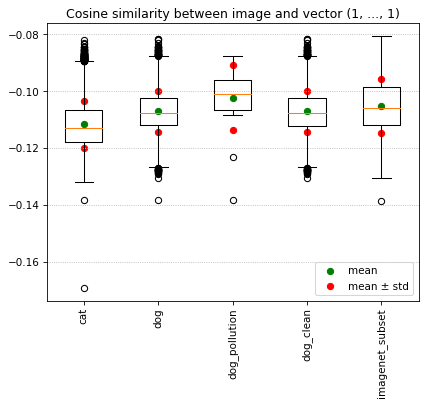

In [ ]:
reference_vector = torch.ones((1, embedding_dim))
similarity_values = {}
for label in LABELS_POLLUTION_ALSO:
  similarity_values[label] = [cos_sim[0] for cos_sim in cosine_similarity(image_embeddings[label], reference_vector)]
  #print(f'Cosine similarity of reference vector and "{label}" text embedding is', cosine_similarity(reference_vector, text_embeddings_word[label]))
show_boxplot(similarity_values, 'Cosine similarity between image and vector (1, ..., 1)')

##### Get similarity values for median vector:

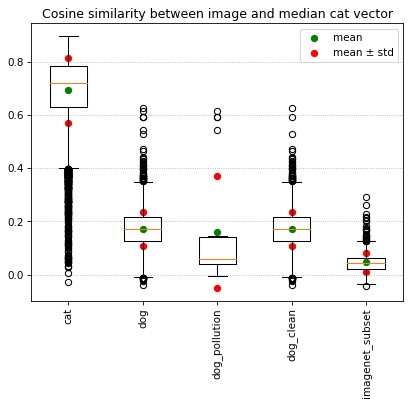

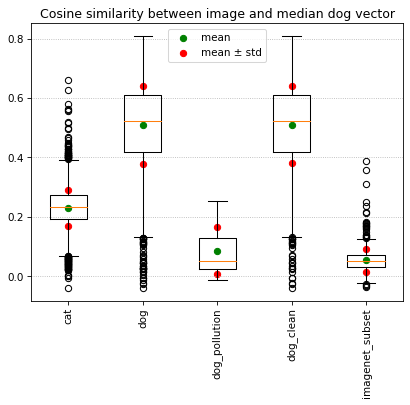

In [ ]:
for true_label in LABELS:
  similarity_values = {}
  reference_vector = torch.quantile(image_embeddings[true_label], q=0.5, dim=0).unsqueeze(0)
  #print(f'Cosine similarity of median "{true_label}" vector and "{true_label}" text embedding is', cosine_similarity(reference_vector, text_embeddings_word[true_label]))
  for label in LABELS_POLLUTION_ALSO:
    similarity_values[label] = [cos_sim[0] for cos_sim in cosine_similarity(image_embeddings[label], reference_vector)]
  show_boxplot(similarity_values, f'Cosine similarity between image and median {true_label} vector')

##### Get similarity values for mean vector

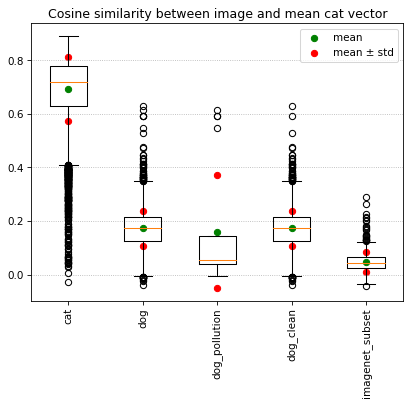

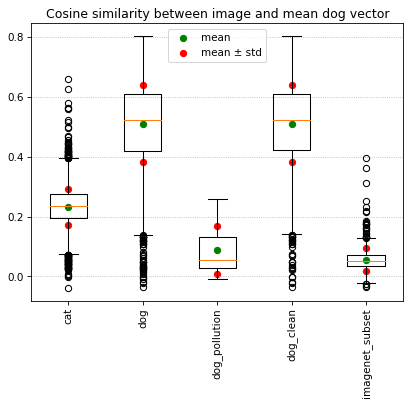

In [ ]:
for true_label in LABELS:
  similarity_values = {}
  reference_vector = torch.mean(image_embeddings[true_label], dim=0).unsqueeze(0)
  #print(f'Cosine similarity of mean "{true_label}" vector and "{true_label}" text embedding is', cosine_similarity(reference_vector, text_embeddings_word[true_label]))
  for label in LABELS_POLLUTION_ALSO:
    similarity_values[label] = [cos_sim[0] for cos_sim in cosine_similarity(image_embeddings[label], reference_vector)]
  show_boxplot(similarity_values, f'Cosine similarity between image and mean {true_label} vector')

##### Get similarity values for text embedding:

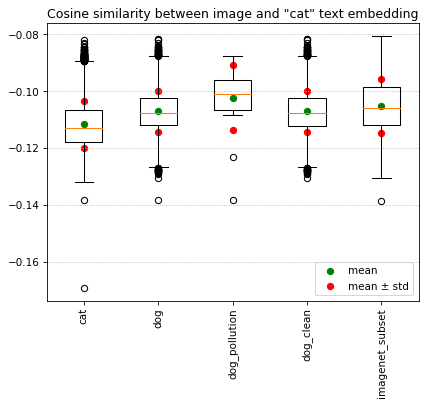

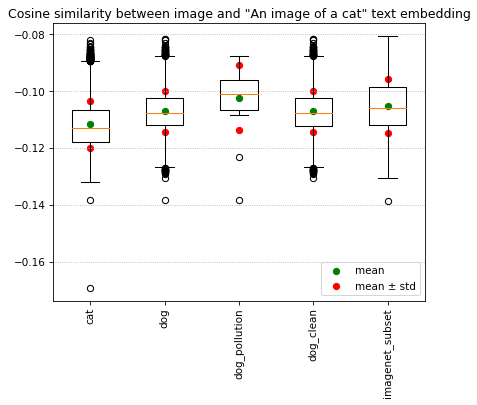

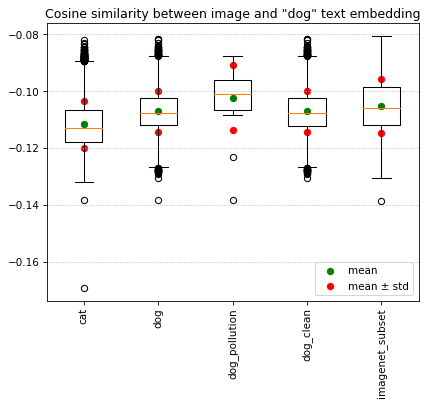

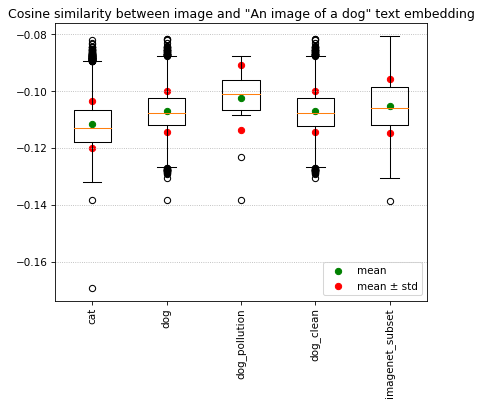

In [ ]:
for true_label in LABELS:
  for i, text_embeddings in enumerate([text_embeddings_word, text_embeddings_sentence]):
    similarity_values = {}
    for label in LABELS_POLLUTION_ALSO:
      similarity_values[label] = [cos_sim[0] for cos_sim in cosine_similarity(image_embeddings[label], text_embeddings[true_label])]
    show_boxplot(similarity_values, f'Cosine similarity between image and "{("" if i == 0 else "An image of a ") + true_label}" text embedding')

##### Compare pairwise similarity

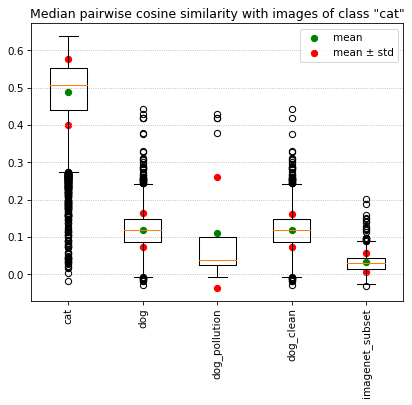

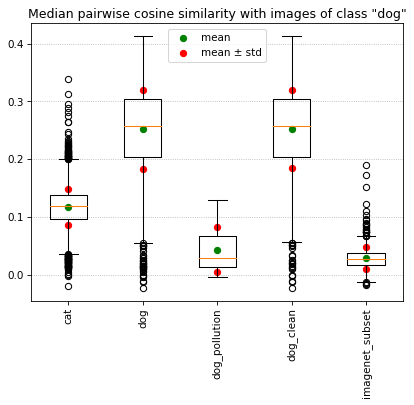

In [ ]:
all_image_embeddings = []
indices_where_new_class_starts = [0]
for i, label in enumerate(LABELS_POLLUTION_ALSO):
  indices_where_new_class_starts.append(indices_where_new_class_starts[-1] + len(image_embeddings[label]))
  all_image_embeddings.append(image_embeddings[label])
all_image_embeddings = torch.cat(all_image_embeddings)

all_similarity_values = cosine_similarity(all_image_embeddings.clone().detach())

similarity_values = {}
for i, label in enumerate(LABELS):
  similarity_values[label] = {}
  start = indices_where_new_class_starts[i]
  end = indices_where_new_class_starts[i+1]
  similarity_values_label = np.median(all_similarity_values[start:end], axis=0)
  for j, label_ in enumerate(LABELS_POLLUTION_ALSO):
    start_ = indices_where_new_class_starts[j]
    end_ = indices_where_new_class_starts[j+1]
    similarity_values[label][label_] = similarity_values_label[start_:end_]

for true_label in LABELS:
  show_boxplot(similarity_values[true_label], f'Median pairwise cosine similarity with images of class "{true_label}"')

##### Compare cosine similarities with the embedding having the highest median cosine similarity

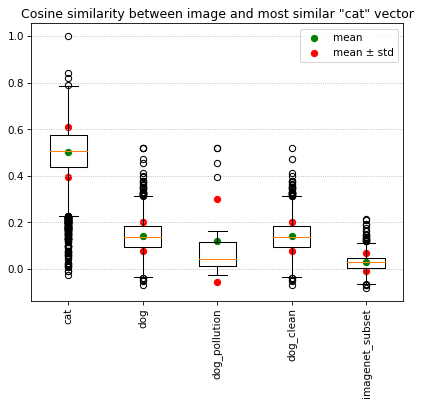

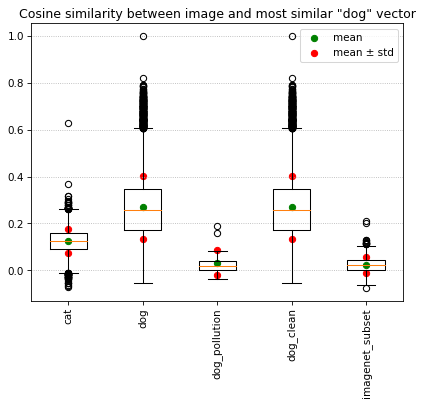

In [ ]:
for i, true_label in enumerate(LABELS):
  similarity_values = {}
  start = indices_where_new_class_starts[i]
  end = indices_where_new_class_starts[i+1]
  similarity_values_label = np.median(all_similarity_values[start:end, start:end], axis=0)
  reference_vector = all_image_embeddings[np.argsort(similarity_values_label)[len(similarity_values_label)//2] + start].reshape(1, -1)
  #print(f'Cosine similarity of highest median cos.sim. {true_label} vector and {true_label} text embedding is', cosine_similarity(text_embeddings_word[true_label], reference_vector))
  for label in LABELS_POLLUTION_ALSO:
    similarity_values[label] = [cos_sim[0] for cos_sim in cosine_similarity(image_embeddings[label], reference_vector)]
  show_boxplot(similarity_values, f'Cosine similarity between image and most similar "{true_label}" vector')

# Analyzing on corrupted data

##### Functions for evaluation

In [ ]:
def evaluate(similarity_values, ground_truth, predict_if_mislabeled_function, outliers_on_both_sides=False, stds_tolerated_searchspace=None, return_all=False, plot=False, mismatches=None, strategy=None, label=None):
  """
  CM in shape
  [[TN, FP],
   [FN, TP]]
  """

  if stds_tolerated_searchspace is None:
    stds_tolerated_searchspace = np.arange(0.1, 5.0001 if MISMATCH_PORTION >= 0.049 else 8.0001, 0.01)
  if mismatches is None:
    mismatches = {}
  if strategy is None:
    strategy = ''
  if label is None:
    label = ''

  precisions = []
  recalls = []
  recalls_per_type = {key: [] for key in mismatches}
  f1s = []
  accuracies = []
  confusion_matrices = []
  for stds_tolerated in stds_tolerated_searchspace:
    predictions = predict_if_mislabeled_function(similarity_values, outliers_on_both_sides, stds_tolerated)
    precisions.append(precision_score(ground_truth, predictions, zero_division=1.0))
    recalls.append(recall_score(ground_truth, predictions, zero_division=1.0))
    f1s.append(f1_score(ground_truth, predictions, zero_division=1.0))
    accuracies.append(accuracy_score(ground_truth, predictions))
    confusion_matrices.append(confusion_matrix(ground_truth, predictions, labels=[False, True]))
    for key in mismatches:
      recalls_per_type[key].append(recall_score(ground_truth[mismatches[key][0]:mismatches[key][1]], predictions[mismatches[key][0]:mismatches[key][1]], zero_division=0.0))

  best_index = np.argmax(f1s)
  best_metrics = {
      'stds_tolerated': stds_tolerated_searchspace[best_index],
      'f1': f1s[best_index],
      'precision': precisions[best_index],
      'recall': recalls[best_index],
      'accuracy': accuracies[best_index],
      'confusion_matrix': confusion_matrices[best_index]
  }
  for key in mismatches:
    best_metrics['recall_' + key] = recalls_per_type[key][best_index]

  if plot:
    plt.plot(stds_tolerated_searchspace, precisions, label='precision')
    plt.plot(stds_tolerated_searchspace, recalls, label='recall')
    plt.plot(stds_tolerated_searchspace, f1s, label='f1')
    plt.plot(stds_tolerated_searchspace, accuracies, label='accuracy')
    plt.title(f'Mismatch identification for class "{label}" with strategy "{strategy}"')
    plt.xlabel('stds_tolerated')
    plt.grid(linestyle='dotted')
    plt.legend()
    plt.show()

  if return_all:
    metrics = {
        'best_metrics': best_metrics,
        'all_metrics': {
            'stds_tolerated_searchspace': stds_tolerated_searchspace,
            'f1s': f1s,
            'precisions': precisions,
            'recalls': recalls,
            'accuracies': accuracies,
            'confusion_matrices': confusion_matrices
        }
    }
    for key in mismatches:
      metrics['all_metrics']['recall_' + key] = recalls_per_type[key][best_index]
    return metrics
  else:
    return best_metrics

In [ ]:
def predict_if_mismatch(similarity_values, outliers_on_both_sides=False, stds_tolerated=1):
  median_similarity = np.median(similarity_values)
  tolerated_deviation = stds_tolerated * np.std(similarity_values)
  if not outliers_on_both_sides:
    return similarity_values < median_similarity - tolerated_deviation
  else:
    outliers_high_value = similarity_values > median_similarity + tolerated_deviation
    outliers_low_value = similarity_values < median_similarity - tolerated_deviation
    outliers = np.logical_or(outliers_high_value, outliers_low_value)
    return outliers

### Analyzing on pollution already being in the dataset

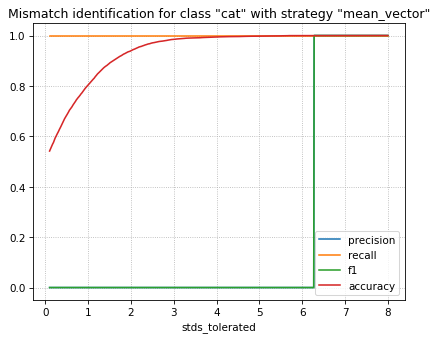

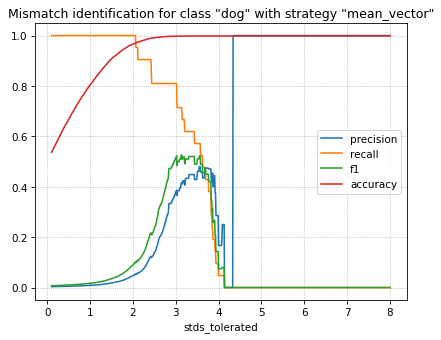


##################          RESULTS FOR EACH CLASS            ##################

Evaluation for class "cat":

1.) strategy: mean_vector (f1 = 1.0)
---
stds_tolerated:       6.279999999999997
f1:                   1.0
precision:            1.0
recall:               1.0
accuracy:             1.0
confusion_matrix: 
[[12502     0]
 [    0     0]]

Evaluation for class "dog":

1.) strategy: mean_vector (f1 = 0.5263157894736842)
---
stds_tolerated:       3.1299999999999986
f1:                   0.5263157894736842
precision:            0.4166666666666667
recall:               0.7142857142857143
accuracy:             0.9978398271861749
confusion_matrix: 
[[12457    21]
 [    6    15]]

##################        RESULTS FOR WHOLE DATASET           ##################

1.) strategy: mean_vector (f1 = 0.5263157894736842)
---
f1:                   0.5263157894736842
precision:            0.4166666666666667
recall:               0.7142857142857143
accuracy:             0.9989200431982721
confusion

In [ ]:
if mislabeled_indices is not None:
  evaluations = {}

  for label in LABELS:

    if label not in mislabeled_indices:
      continue

    evaluations[label] = []
    embeddings_mixed = image_embeddings[label].clone().detach()
    ground_truth = mislabeled_indices[label]

    # compare strategies to identify corrupted data
    for strategy in STRATEGIES:

      if strategy == 'pairwise_similarity':
        similarity_values = np.median(cosine_similarity(embeddings_mixed), axis=0)
      else:
        if strategy == 'fixed_reference_vector':
          reference_vector = torch.ones((1, embeddings_mixed.shape[1]))
        elif strategy == 'mean_vector':
          reference_vector = torch.mean(embeddings_mixed, dim=0).unsqueeze(0)
        elif strategy == 'median_vector':
          reference_vector = torch.quantile(embeddings_mixed, q=0.5, dim=0).unsqueeze(0)
        elif strategy == 'most_similar_vector':
          similarity_values_label = np.median(cosine_similarity(embeddings_mixed), axis=0)
          reference_vector = embeddings_mixed[np.argsort(similarity_values_label)[len(similarity_values_label)//2]].reshape(1, -1)
        elif strategy == 'text_embedding_vector':
          reference_vector = text_embeddings_word[label]
        else:
          raise ValueError('Strategy not implemented!')
        similarity_values = [cos_sim[0] for cos_sim in cosine_similarity(embeddings_mixed, reference_vector)]

      if strategy == 'fixed_reference_vector':
        outliers_on_both_sides = True
      else:
        outliers_on_both_sides = False

      evaluation = {'strategy': strategy}
      evaluation['metrics'] = evaluate(similarity_values, ground_truth, predict_if_mismatch, outliers_on_both_sides, plot=True, strategy=strategy, label=label, stds_tolerated_searchspace=np.arange(0.1, 8.0001, 0.01))
      evaluations[label].append(evaluation)

    evaluations[label].sort(key=lambda x: x['metrics']['f1'], reverse=True)

  print('\n' + '=' * 80 + '\n##################          RESULTS FOR EACH CLASS            ##################\n' + '=' * 80)
  for label in LABELS:
    print('\n' + '=' * 80 + f'\nEvaluation for class "{label}":\n' + '=' * 80)
    for i, evaluation in enumerate(evaluations[label]):
      print(f"\n{i+1}.) strategy: {evaluation['strategy']} (f1 = {evaluation['metrics']['f1']})\n---")
      for metric in evaluation['metrics']:
        separator = ' ' * (20 - len(metric)) if metric != 'confusion_matrix' else '\n'
        print(f"{metric}: {separator}{evaluation['metrics'][metric]}")

  print('\n' + '=' * 80 + '\n##################        RESULTS FOR WHOLE DATASET           ##################\n' + '=' * 80)
  overall_metrics = {}

  for label in LABELS:
    for evaluation in evaluations[label]:
      if evaluation['strategy'] not in overall_metrics:
        overall_metrics[evaluation['strategy']] = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
      cm = evaluation['metrics']['confusion_matrix']
      overall_metrics[evaluation['strategy']]['tn'] += cm[0][0]
      overall_metrics[evaluation['strategy']]['fp'] += cm[0][1]
      overall_metrics[evaluation['strategy']]['fn'] += cm[1][0]
      overall_metrics[evaluation['strategy']]['tp'] += cm[1][1]

  total = sum(list(overall_metrics.values())[0].values())

  results = []
  for strategy in STRATEGIES:
    accuracy = (overall_metrics[strategy]['tp'] + overall_metrics[strategy]['tn']) / total
    precision = overall_metrics[strategy]['tp'] / (overall_metrics[strategy]['tp'] + overall_metrics[strategy]['fp'])
    recall = overall_metrics[strategy]['tp'] / (overall_metrics[strategy]['tp'] + overall_metrics[strategy]['fn'])
    f1 = 2 * precision * recall / (precision + recall)
    cm = np.array([[overall_metrics[strategy]['tn'], overall_metrics[strategy]['fp']], [overall_metrics[strategy]['fn'], overall_metrics[strategy]['tp']]])
    results.append({'strategy': strategy})
    results[-1]['metrics'] = {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

  results.sort(key=lambda x: x['metrics']['f1'], reverse=True)

  for i, evaluation in enumerate(results):
    print(f"\n{i+1}.) strategy: {evaluation['strategy']} (f1 = {evaluation['metrics']['f1']})\n---")
    for metric in evaluation['metrics']:
      separator = ' ' * (20 - len(metric)) if metric != 'confusion_matrix' else '\n'
      print(f"{metric}: {separator}{evaluation['metrics'][metric]}")

### Analyzing on external pollution

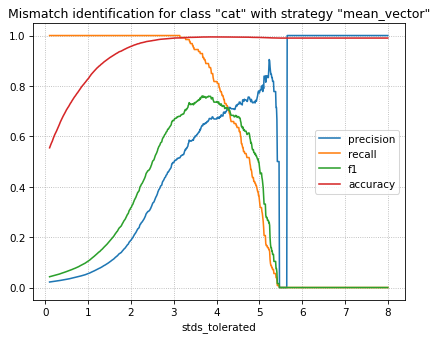

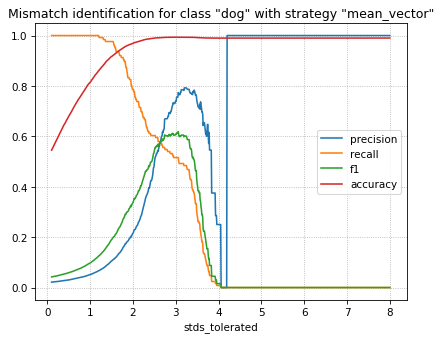

In [ ]:
evaluations = {}

for label in LABELS:

  evaluations[label] = []

  relevant_embeddings = image_embeddings[label]
  if label + '_clean' in image_embeddings:
    relevant_embeddings = image_embeddings[label + '_clean']

  # calculate how much corrupted data to add
  start_index_of_corruption = len(relevant_embeddings) + 1
  n_other_labels = len(LABELS) - 1
  corruption_amount_total = round(len(relevant_embeddings) / (1 - MISMATCH_PORTION)) - len(relevant_embeddings)
  corruption_amount_interclass = round(corruption_amount_total * MANIPULATION_TYPES[0])
  corruption_amount_imagenet = corruption_amount_total - corruption_amount_interclass
  corruption_amount_per_class = [corruption_amount_interclass // n_other_labels for _ in range(n_other_labels - 1)]
  corruption_amount_per_class.append(corruption_amount_interclass - sum(corruption_amount_per_class))  # compensate rounding difference
  mismatches = {
      'interclass': (start_index_of_corruption, start_index_of_corruption + corruption_amount_interclass),
      'imagenet': (start_index_of_corruption + corruption_amount_interclass, start_index_of_corruption + corruption_amount_interclass + corruption_amount_imagenet)
  }

  # prepare mix of correct data and corrupted data
  embeddings_mixed = relevant_embeddings.clone().detach()
  corruption_label_index = 0
  for corruption_label in LABELS:
    if corruption_label != label and corruption_label != 'imagenet_subset':
      embeddings_mixed = torch.cat((embeddings_mixed, image_embeddings[corruption_label][:corruption_amount_per_class[corruption_label_index]]))
      corruption_label_index += 1
  if corruption_amount_imagenet > 0:
    embeddings_mixed = torch.cat((embeddings_mixed, image_embeddings['imagenet_subset'][:corruption_amount_imagenet]))
  ground_truth = [False for _ in range(len(relevant_embeddings))] + [True for _ in range(corruption_amount_total)]

  # compare strategies to identify corrupted data
  for strategy in STRATEGIES:

    if strategy == 'pairwise_similarity':
      similarity_values = np.median(cosine_similarity(embeddings_mixed), axis=0)
    else:
      if strategy == 'fixed_reference_vector':
        reference_vector = torch.ones((1, embeddings_mixed.shape[1]))
      elif strategy == 'mean_vector':
        reference_vector = torch.mean(embeddings_mixed, dim=0).unsqueeze(0)
      elif strategy == 'median_vector':
        reference_vector = torch.quantile(embeddings_mixed, q=0.5, dim=0).unsqueeze(0)
      elif strategy == 'most_similar_vector':
        similarity_values_label = np.median(cosine_similarity(embeddings_mixed), axis=0)
        reference_vector = embeddings_mixed[np.argsort(similarity_values_label)[len(similarity_values_label)//2]].reshape(1, -1)
      elif strategy == 'text_embedding_vector':
        reference_vector = text_embeddings_word[label]
      else:
        raise ValueError('Strategy not implemented!')
      similarity_values = [cos_sim[0] for cos_sim in cosine_similarity(embeddings_mixed, reference_vector)]

    if strategy == 'fixed_reference_vector':
      outliers_on_both_sides = True
    else:
      outliers_on_both_sides = False

    evaluation = {'strategy': strategy}
    evaluation['metrics'] = evaluate(similarity_values, ground_truth, predict_if_mismatch, outliers_on_both_sides, plot=True, mismatches=mismatches, strategy=strategy, label=label)
    evaluations[label].append(evaluation)

  evaluations[label].sort(key=lambda x: x['metrics']['f1'], reverse=True)

#### Results for each class:

In [ ]:
for label in LABELS:
  print('\n' + '=' * 80 + f'\nEvaluation for class "{label}":\n' + '=' * 80)
  for i, evaluation in enumerate(evaluations[label]):
    print(f"\n{i+1}.) strategy: {evaluation['strategy']} (f1 = {evaluation['metrics']['f1']})\n---")
    for metric in evaluation['metrics']:
      separator = ' ' * (20 - len(metric)) if metric != 'confusion_matrix' else '\n'
      print(f"{metric}: {separator}{evaluation['metrics'][metric]}")


Evaluation for class "cat":

1.) strategy: mean_vector (f1 = 0.7597402597402597)
---
stds_tolerated:       3.6599999999999984
f1:                   0.7597402597402597
precision:            0.6428571428571429
recall:               0.9285714285714286
accuracy:             0.9941400063351283
confusion_matrix: 
[[12437    65]
 [    9   117]]
recall_interclass:    0.8571428571428571
recall_imagenet:      1.0

Evaluation for class "dog":

1.) strategy: mean_vector (f1 = 0.6190476190476191)
---
stds_tolerated:       3.0599999999999987
f1:                   0.6190476190476191
precision:            0.7738095238095238
recall:               0.5158730158730159
accuracy:             0.9936528086321803
confusion_matrix: 
[[12459    19]
 [   61    65]]
recall_interclass:    0.06349206349206349
recall_imagenet:      0.9838709677419355


#### Results for whole dataset:

In [ ]:
overall_metrics = {}

for label in LABELS:
  for evaluation in evaluations[label]:
    if evaluation['strategy'] not in overall_metrics:
      overall_metrics[evaluation['strategy']] = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
    cm = evaluation['metrics']['confusion_matrix']
    overall_metrics[evaluation['strategy']]['tn'] += cm[0][0]
    overall_metrics[evaluation['strategy']]['fp'] += cm[0][1]
    overall_metrics[evaluation['strategy']]['fn'] += cm[1][0]
    overall_metrics[evaluation['strategy']]['tp'] += cm[1][1]

total = sum(list(overall_metrics.values())[0].values())

results = []
for strategy in STRATEGIES:
  accuracy = (overall_metrics[strategy]['tp'] + overall_metrics[strategy]['tn']) / total
  precision = overall_metrics[strategy]['tp'] / (overall_metrics[strategy]['tp'] + overall_metrics[strategy]['fp'])
  recall = overall_metrics[strategy]['tp'] / (overall_metrics[strategy]['tp'] + overall_metrics[strategy]['fn'])
  f1 = 2 * precision * recall / (precision + recall)
  cm = np.array([[overall_metrics[strategy]['tn'], overall_metrics[strategy]['fp']], [overall_metrics[strategy]['fn'], overall_metrics[strategy]['tp']]])
  results.append({'strategy': strategy})
  results[-1]['metrics'] = {
      'f1': f1,
      'precision': precision,
      'recall': recall,
      'accuracy': accuracy,
      'confusion_matrix': cm
  }

results.sort(key=lambda x: x['metrics']['f1'], reverse=True)

In [ ]:
for i, evaluation in enumerate(results):
  print(f"\n{i+1}.) strategy: {evaluation['strategy']} (f1 = {evaluation['metrics']['f1']})\n---")
  for metric in evaluation['metrics']:
    separator = ' ' * (20 - len(metric)) if metric != 'confusion_matrix' else '\n'
    print(f"{metric}: {separator}{evaluation['metrics'][metric]}")


1.) strategy: mean_vector (f1 = 0.7027027027027027)
---
f1:                   0.7027027027027027
precision:            0.6842105263157895
recall:               0.7222222222222222
accuracy:             0.9938966391883323
confusion_matrix: 
[[24896    84]
 [   70   182]]


# Check that everything went fine

In [ ]:
if USE_CACHED_EMBEDDINGS != '' and USE_CACHED_EMBEDDINGS.split('__')[0] != 'CREATE':
  pickle_file = datasets_path + USE_CACHED_EMBEDDINGS
  with open(pickle_file, 'rb') as f:
    image_embeddings2 = pickle.load(f)

  LABELS_POLLUTION_ALSO = LABELS.copy()
  mislabeled_indices2 = None

  if MISLABELED_INSTANCES != '':
    with open(datasets_path + MISLABELED_INSTANCES, 'rb') as f:
      mislabeled_indices2 = pickle.load(f)
    for label in mislabeled_indices2:
      if len(mislabeled_indices2[label]) == 0 or sum(mislabeled_indices2[label]) == 0:
        continue
      image_embeddings2[label + '_pollution'] = image_embeddings2[label][mislabeled_indices2[label]].clone().detach()
      image_embeddings2[label + '_clean'] = image_embeddings2[label][[not i for i in mislabeled_indices2[label]]].clone().detach()
      LABELS_POLLUTION_ALSO += [label + '_pollution', label + '_clean']

  if MANIPULATION_TYPES[1] > 0:
    pickle_file = datasets_path + IMAGENET_EMBEDDINGS
    with open(pickle_file, 'rb') as f:
      image_embeddings2['imagenet_subset'] = pickle.load(f)['val']
    print('Embeddings loaded from', pickle_file)
    LABELS_POLLUTION_ALSO += ['imagenet_subset']

  for key in image_embeddings:
    print('Checking key', key)
    assert torch.equal(image_embeddings[key], image_embeddings2[key])
    if key in LABELS and key + '_pollution' in image_embeddings:
      print('Checking correctness of', key + '_pollution and', key + '_clean')
      assert torch.equal(image_embeddings[key][mislabeled_indices[key]], image_embeddings[key + '_pollution'])
      assert torch.equal(image_embeddings[key][[not i for i in mislabeled_indices2[key]]], image_embeddings[key + '_clean'])

Embeddings loaded from /content/drive/My Drive/FM/datasets/ViT-CLS_imagenet-subset.pkl
Checking key cat
Checking key dog
Checking correctness of dog_pollution and dog_clean
Checking key dog_pollution
Checking key dog_clean
Checking key imagenet_subset
